In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
%matplotlib inline

# K-means algorithm

Objective: identifying clusters of data points in a multi-dimensional space

Dataset: $x = {x_1, x_2, ..., x_N}$ consisting of $N$ observations in a $D$-dimensions.

Representation: $mu_k$ to be the center of the $k^{th}$ cluster with which a partition of the observations are assigned to.

Goal: To find the assignment of data points to clusters, as well as a set of vectors ${\mu_k}$, such that the sum of squared distances of each data point to its closest cluster center is minimized

Objective function:
<center> $J = \sum_{n=1}^{N}\sum_{k=1}^{K} r_{nk} \lvert\lvert{x_n-\mu_k}\rvert\rvert^2$</center>
where $r_{nk} \in (0, 1)$ is a binary indicator variable that equals to 1 when the data point $x_n$ belongs to a cluster $k$ and $0$ otherwise. It is our hard calssifier. Our goal becomes to find $r_{nk}$ and $\mu_k$ such that this cost function is minimized.

To determine $r_{nk}$, the cluster assignments, we fix $\mu_k$ and for each point $n$ we assign it to $k^{th}$ cluster that results in the minimum value for $\lvert\lvert{x_n-\mu_k}\rvert\rvert^2$.

Once the clusters have been assigned, we proceed to minimize the cost function for the optimal value for $\mu_k$. This is done easily by differentiating the cost function with respect to $\mu_k$, setting it to zero and solving for $\mu_k$, resulting in:

<center> $\mu_k = \frac{\sum_{n}r_{nk}x_n}{\sum_{n}r_{nk}}$</center>

which can be interpreted intuitively as the mean of all of the points for a given cluster, hence, k-means.

This process of cluster assignment and updating the cluster centers is repeated until there is no more change in the cluster assignments. Convergence to a local optima is guaranteed, but whether it is the optimal solution or not depends on the initialization of $\mu_k$.

In [3]:
def initialization(x, K):
    """Randomly selects K points from the data set to be assigned as the cluster centers
    Input: x: n data points in d dimensions
           K: number of clusters
    Output: mu: k vectors in d dimensions
    """
    n, _ = X.shape
    mu = X[np.random.choice(n, K, replace=False)]
    return mu

In [5]:
def cluster_assignment(x, mus):
    """ Assigns every data point to the nearest cluster
    Input: x: data set
           mus: vector containing cluster centers
    output: y: labels assigning the assignment of a datapoint to its nearest cluster
            distortion: total cost/distortion associated with cluster assignments
    
    """
    n, _ = X.shape
    K, _ = mus.shape
    cost = 0
    r = np.zeros((n, K))
    for i in range(n):
        sum_of_squared_distances = []
        for j in range(K):
            sum_of_squared_distances.append(np.linalg.norm(X[i,:] - mus[j])**2)
        idx = np.argmin(sum_of_squared_distances)
        r[i, idx] = 1
        
    return r

In [6]:
def cluster_update(x, r, mus):
    """ Updates the new cluster centers based on the assignments of each data point
    Input: x: dataset
           y: cluster assignment
           mus: cluster centers
    Output: new_mus: updated cluster centers
    """
    n, d = X.shape
    k, _ = mus.shape

    cost = 0
    mu = np.zeros((k, d))

    for j in range(k):
        mu[j, :] = r[:, j] @ x / r[:,j].sum(axis=0)
        sse = ((mu[j] - x)**2).sum(axis=1) @ r[:, j]
        cost += sse

    return mu, cost

In [7]:
def run_kmeans(x, K, plot = True, eps=1e-6):
    """Runs the k-means algorithm
    Input: x: data set
           K: number of K clusters
           plot: boolean if plot is desired
           eps: termination criteria
    Output: mus: final cluster centers
            distortion: final cost/distortion
    """
    mus = initialization(x, K)
    
    old_cost = None
    cost = None
    
    while old_cost is None or np.abs(old_cost-cost)>=eps:
        old_cost = cost
        r = cluster_assignment(x, mus)
        mus, cost = cluster_update(x, r, mus)
        
    
    if plot:
        plotData(X, mus, r)
        
    
    return mus, cost

In [13]:
def opt_k(x, maxK=10):
    """ Finds the optimal number of clusters for given data set using the so-called elbow method
    input: data set
    output: plot of distortions associated with number of clusters
    """
    costs = []
    
    for i in range(1,maxK):
        _, cost = run_kmeans(x, i, plot=False)
        costs.append(cost)
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(1,maxK), costs)
    plt.xlabel('Number of clusters K')
    plt.ylabel('Cost')
    
    return plt.show()    

In [2]:
def plotData(x, mus=[], r=[]):
    """ Plots the scatter data for a 2-dimensional dataset"""
    n, d = x.shape
    assert d == 2, "Oh no! Wrong dimension size!"
    
    plt.figure(figsize=(16,8))
    if len(mus)==0:
        plt.scatter(X[:, 0], X[:, 1], s=50);
    else:
        k, _ = mus.shape
        
        
        y = [np.argmax(i) for i in r]
        

        plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
        plt.scatter(mus[:, 0], mus[:, 1], c='black', s=200, alpha=0.5);

    return plt.show()

In [68]:
# test on a random data set
X, _ = make_blobs(n_samples=1000, centers=5,
                       cluster_std=0.8, random_state=2)

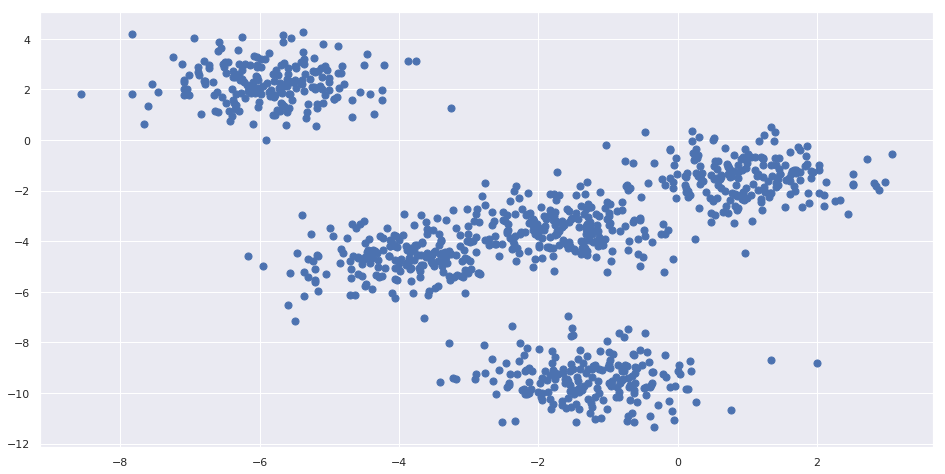

In [69]:
# visualize data
plotData(X)

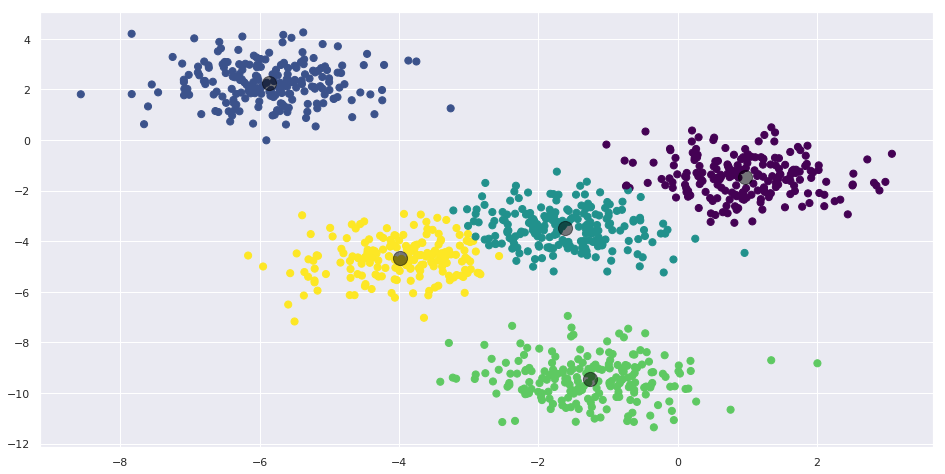

In [73]:
_ = run_kmeans(X, 5)

In [74]:
# try it on the toy dataset

X = np.loadtxt("DataScienceandStatistics/Course4/Project4/resources_netflix/netflix/toy_data.txt")

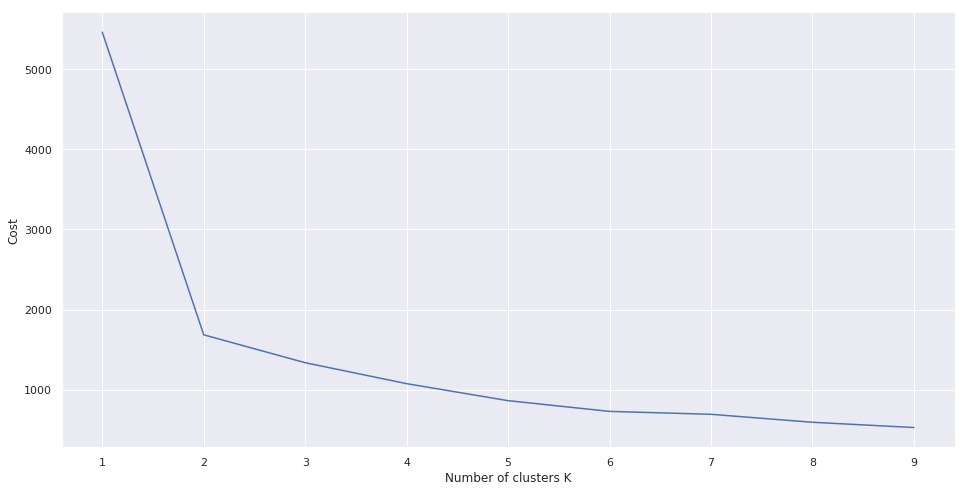

In [75]:
_ = opt_k(X)

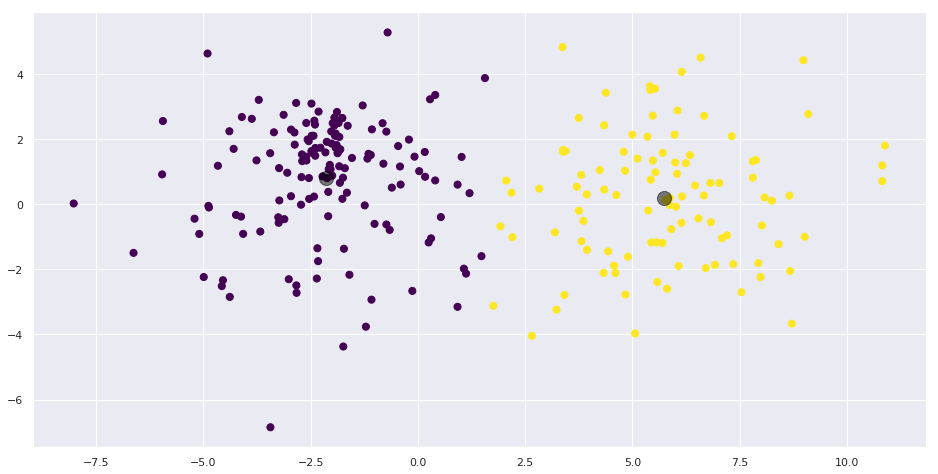

In [76]:
_ = run_kmeans(X, 2)

# Expectation Maximization algorithm

The EM algorithm can be seen as a generalization of the K-means algorithm, with the key difference of being a soft classifier, i.e. very point is assigned to a cluster with a given probability. Therefore it is probabilistic in nature, and the clusters can be modelled in terms of multinomial or gaussian distributions instead of a single $\mu$ vector as was the case for k-means. And the cluster assignment step, or the expectation step of the EM algorithm, assigns the maximum likelihood of a given cluster to be assigned to the data points. The EM algorithm creates a generative model, in that after the clusters have been found, we can generate new data that resembles our old data.

Given an observed data set $x={x_1, x_2, ..., x_n}$, the probabilistic model of the data is given as:
<br>
<center>$P(x \mid \theta) = \prod_{i=1}^{n}P(x_i \mid \theta)$</center>
<br>
The parameters can be estimated either by the Maximum Likelihood Estimation (MLE) or by the Maximum a Posteriori (MAP):
<br>
- MLE: $\hat{\theta}_{ML}=argmax_\theta [P(x \mid \theta)]$
<br>
- MAP: $\hat{\theta}_{MAP} = argmax_\theta[P(\theta)*p(x \mid \theta)]$
<br>
and it is apparent that the MLE is equivalent to the MAP when the prior distribution, $P(\theta)$ is uniform.

## Binomial Generative Model

Problem statement:
     We have two coins, $A$ and $B$, with unknown biases $\theta_A$ and $\theta_B$, respectively. We devise a coin flipping experiment in order to deterimine the biases.
          
Experiment:
     Randomly select one of the two coins with equal probability $\pi_A=\pi_B$ and perform m tosses with that coin and note the number of heads that show up. We repeat this experiment $n$ times resulting with a total of $mn$ coin tosses.
     
We denote the vector $x = (x_1, x_2, ..., x_n)$ where $x_i \in (0, 1, ...m)$, i.e. the number of heads observed in the $i^{th}$ trial, and $z = (z_1, z_2, ... , z_n)$ where $z_i \in (A, B)$ which is the identity of the coin in the $i^{th}$ trial.

### Case I: Identity of coins known (complete data case)

We will use the Maximum a Posteriori principal to estimate the bias. From Bayes' rule, the probability for the $i^{th}$ trial having selected coin $z_i = j$ where $j \in (A, B)$ given that $x_i$ heads out of $m$ tosses were observed is:
<br>
<br>
<center>$P(z_i=j \mid x_i) = \frac{\pi_{j}P(x_i \mid z_i=j)}{P(x_i)}=f(x_i)\pi_{j}{{m}\choose{x_i}} \theta_{j}^{x_i}(1-\theta_{j})^{m-x_i}$</center>
<br>
where $f(x_i)$ is some function of $x_i$ independent of $\theta_{j}$, $\pi_{j}$ is the probability of selecting coin $j$, and $P(x_i \mid z_i=j)$ is the probability of observing $x_i$ heads given coin $z_i=j$ was selected, which is just the binomial distribution.

We can estimate the most likely $\theta_j$ by maximizing the log of this function. 
<br>
<br>
<center>$log(P(z_i=j \mid x_i)) = x_ilog\theta_{j} + (m-x_i)log(1-\theta_{j}) + constant$</center>
<br>
Differentiating w.r.t. $\theta_{j}$ and equating to zero:
<br>
<center>$\frac{d}{d\theta_{j}}log(P(z_i=j \mid x_i)) = \frac{x_i}{\hat{\theta_{j}}} - \frac{m-x_i}{1-\hat{\theta_{j}}} = 0 $</center>
<br>
which intuitively yields:
<br>
<center>$\hat{\theta}_{j} = \frac{x_i}{m}$</center>
<br>
We can define a binary vector $r_{ij}$, that equals to $1$ in the case where ${i^{th}}$ trial used coin $j$ and 0 otherwise. So $r$ is an $nxd$ matrix where the rows correspond to the trial and the columns correspond to the coin used, and $d$ is equal to the number of coins used, which in our case is $2$.

Therefore, we can write for the corresponding $\hat{\theta}_j$ by summing over all of the trials:
<br>
<br>
<center>$\hat{\theta}_j = \frac{\sum_{i=1}^{n}r_{ij}x_i}{m\sum_{i=1}^{n}r_{ij}}$</center>
<br>
where $m$ is the number of flips for a given trial. In other words, the bias for coin $j$ is computed as the ratio of the number of heads using coin $j$ to the total number of flips using coin j.

In [2]:
# initialize the unknown biases

theta = np.array([0.25, 0.75])

d = len(theta)
m = 10
n = 50

coins = np.array(['A', 'B'])
p_A = p_B = 0.5
p = [p_A, p_B]

r = np.zeros((n, d))

for i in range(n):
    coin_used = np.random.choice(coins, p=p)
    r[i,np.where(coins == coin_used)] = 1
r

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [3]:
# start the experiment
outcomes = np.zeros((n,m))

theta_estimate = r@theta

for i in range(n):
    for j in range(m):
        outcome = np.random.choice([1, 0], p=[theta_estimate[i], 1-theta_estimate[i]])
        outcomes[i][j] = outcome
outcomes

array([[0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0., 0., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 

In [4]:
# we can now calculate the most likely biases for the coins based on the result of the experiment
theta_estimate = []

for i in range(d):
    theta_estimate.append(np.sum(r[:,i]@outcomes)/(np.sum(r[:,i])*m))
    print('Most likely bias for coin A: ' + str(round(theta_estimate[i], 3)) + '\tTrue bias = ' + str(theta[i]))


Most likely bias for coin A: 0.23	True bias = 0.25
Most likely bias for coin A: 0.759	True bias = 0.75


In [17]:
# We can also extend this to more than 2 coins

# initialize the unknown biases

theta = np.array([0.25, 0.5, 0.75])

d = len(theta)
m = 10
n = 10

coins = np.array(['A', 'B', 'C'])
p_A = p_B = p_C = 1/3
p = [p_A, p_B, p_C]

r = np.zeros((n, d))

for i in range(n):
    coin_used = np.random.choice(coins, p=p)
    r[i][np.where(coins == coin_used)] = 1
r

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [18]:
# start the experiment
outcomes = np.zeros((n,m))

theta_estimate = r@theta

for i in range(n):
    for j in range(m):
        outcome = np.random.choice([1, 0], p=[theta_estimate[i], 1-theta_estimate[i]])
        outcomes[i][j] = outcome
outcomes

array([[1., 1., 0., 1., 1., 0., 1., 0., 1., 1.],
       [1., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1., 1., 0., 1.]])

In [19]:
# we can now calculate the most likely biases for the coins based on the result of the experiment
theta_estimate = []

for i in range(d):
    theta_estimate.append(np.sum(r[:,i]@outcomes)/(np.sum(r[:,i])*m))
    print('Most likely bias for coin '+ coins[i] +': ' + str(round(theta_estimate[i], 3)) + '\tTrue bias = ' + str(theta[i]))

Most likely bias for coin A: 0.175	True bias = 0.25
Most likely bias for coin B: 0.467	True bias = 0.5
Most likely bias for coin C: 0.767	True bias = 0.75


### Case II: Identity of coins unknown (incomplete data case)

We would like to estimate the biases of the coins given a set of observations similar to Case I but with the identities of the coins unknown. This is a classic chicken-and-egg problem: we need the identities of the coins to solve for the bias, and we need the bias in order to figure out what the identity of the coins are.

We will consider the same outcome for the trials in Case I. Since we do not know which coin was used, we not only have to estimate the $\theta$ parameter but also the matrix $r$ which contained the identities of the coins. We'll proceed by solving this problem by iterating over these two steps until convergence:

- E-step: initialize some guesses for $\theta$ and use them to compute the probability that a given trial was due to either coin given the observations. This is the same as the $r$ matrix with the exception that instead of being a matrix of $1$'s and $0$'s, it becomes a matrix of probabilities, i.e. soft cluster assignment.



- M-step: using the probabilities computed in the E-step, we re-estimate the $\theta$ parameters using the MLE which are then in turn fed as $\theta_0$ to the E-step. 

#### Expectation step:
Starting from our initial guess of the parameters, call it $\theta_{0}$, we assign a given trial $i$ not just to the most likely coin, but rather we compute the $P(z_i = j \mid x_i, \theta_{j,0})$ for all trials $i = 1, 2, ..., n$ and all coins $j \in (A, B)$ resulting in a $nx2$ matrix. Therefore, starting with Bayes' rule, the probabilities for a given trial $i$:
<br>
<center>$P(z_i=j \mid x_i) := P(z_i=j \mid x_i; 
\theta_{j,0}) = \frac{\pi_jP(x_i \mid z_i=j; \theta_{j,0})}{\sum_{j' \in(A,B)}P(x_i;\theta_{j',0})}$</center>
<br>
<center>$=\frac{\pi_jP(x_i\mid z_i=j;\theta_{j,0})}{\sum_{j'\in{A,B}}\pi_j'P(x_i \mid z_i=j';\theta_{j',0})}$</center>
<br>

where, for $m$ tosses
<br>

<center>$P(x_i \mid z_i=j;\theta_{j,0})= {{m}\choose{x_i}}\theta_{j,0}^{x_i}(1-\theta_{j,0})^{m-x_i}$</center>
<br>

And finally,

<br>
<br>
<center>$P(z_i=A \mid x_i; \theta_{A,0}) = \frac{\pi_A P(x_i\mid z_i = A;\theta_{A,0})}{\pi_A P(x_i\mid z_i = A;\theta_{A,0}) + \pi_B P(x_i\mid z_i = B;\theta_{B,0})}$</center>
<br>
<center> $= \frac{\pi_A {{m}\choose{x_i}}\theta_{A,0}^{x_i}(1-\theta_{A,0})^{m-x_i}}{\pi_A {{m}\choose{x_i}}\theta_{A,0}^{x_i}(1-\theta_{A,0})^{m-x_i} + \pi_B {{m}\choose{x_i}}\theta_{B,0}^{x_i}(1-\theta_{B,0})^{m-x_i}}$</center>
<br>
<center> $= \frac{\pi_A \theta_{A,0}^{x_i}(1-\theta_{A,0})^{m-x_i}}{\pi_A \theta_{A,0}^{x_i}(1-\theta_{A,0})^{m-x_i} + \pi_B \theta_{B,0}^{x_i}(1-\theta_{B,0})^{m-x_i}}$</center>

and similarly,
<br>
<center>$P(z_i=B \mid x_i;\theta_{B,0}) = \frac{\pi_B \theta_{B,0}^{x_i}(1-\theta_{B,0})^{m-x_i}}{\pi_A \theta_{A,0}^{x_i}(1-\theta_{A,0})^{m-x_i} + \pi_B \theta_{B,0}^{x_i}(1-\theta_{B,0})^{m-x_i}}$</center>
<br>


The function that we wish to maximize over is the log-likelihood of $logP(x,z \mid \theta)$, i.e. the log-likelihood that of our data being generated given the parameters $\theta$.

We use the sum of the log-likelihood $P(x, z;\theta)$ to end the optimization when the absolute difference between the log-likelihood of the previous iteration and the current iteration is less than some threshhold value $\epsilon$. Convergence to a local optima is guaranteed, however, which local optima is dependent on the initial guess for $\theta_0$.

#### Maximization step

The MLE for $\hat{\theta}$ is $argmax_\theta [P(x, z \mid \theta)]$, which we look to maximize. There are a number of ways to do so, most of which do not have closed form solutions, such as gradient methods. In our case, we will make use of Jensen's inequality and compute the lower bound of the log-likelihood function and maximize over that instead. While this binomial problem is simple and straightforward, the formulation can be extended to more elaborate probability distributions.

Jensen's inequality states, for given convex function, that:
<br>
<center> $E[g(x)] \geq g(E[X])$</center>
<br>
with the inequality reversed for concave functions (such as the $log$ function).
Then, starting from the log-likelihood, we have:
<br>
<br>
<center> $logP(x_i\mid \theta_j)=log \sum_j P(x_i, z_i=j \mid \theta_j)$</center>
<br>
<center>$=log\sum_j Q(z_i=j \mid x_i) \frac{P(x_i, z_i=j \mid \theta_j)}{Q(z_i=j \mid x_i)}$</center>
<br>
<center>$=log\mathop{{}\mathbb{E}}_{z_i=j \sim Q(z_i=j\mid x_i)} \frac{P(x_i, z_i=j \mid \theta_j)}{Q(z_i=j \mid x_i)}$</center>
<br>
<center>$\geq \mathop{{}\mathbb{E}}_{z_i=j \sim Q(z_i=j\mid x_i)} log \frac{P(x_i, z_i=j \mid \theta_j)}{Q(z_i=j \mid x_i)}$</center>
<br>
<center>$=\sum_{j}Q(z_i=j \mid x_i) log \frac{P(x_i, z_i=j \mid \theta_j)}{Q(z_i=j \mid x_i)}$</center>
<br>
The equality holds for when $Q(z_i=j \mid x_i) = P(z_i=j \mid x_i, \theta)$

Therefore, we can maximize this lower-bound for the log-likelihood function, and over all data points $x_i=x_1, x_2, ..., x_n$ and biases $\theta_j$ where $j \in (A, B)$, becomes:

<br>
<br>
<center>$logP(x \mid \theta) := \sum_{i=1}^{n}\sum_{j \in (A,B)}P(z_i=j\mid x_i)log\frac{P(x_i, z_i=j ; \theta_j)}{P(z_i=j \mid x_i)}$</center>
<br>

differentiating with resect to $\theta_j$ and equating to zero, the maximum likelihood estimate becomes

<br>
<center>$\hat{\theta}_j = \frac{\sum_{i=1}^{n}P(z_i=j\mid x_i)x_i}{m\sum_{i=1}^{n}P(z_i=j \mid x_i)}$</center>

which is the same as in the case for when the identity of the coins were known, except instead of a binary matrix that takes a value of $1$ when coin $A$ was used and $0$ otherwise, we instead use the *probability* that coin $A$ was used given the data that we have. For each coin, the examples are weighted according to the probability that they belong to that coin. Observing $m$ flips is equivalent to observing $P(z_i=j\mid x_i)*m$ effective flips.


In [20]:
# using outcomes from Case I for our data points x. This time, we do not know the identity of the coins.
x = outcomes
print(x)

[[1. 1. 0. 1. 1. 0. 1. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 1. 0. 1.]]


In [21]:
# E-step
def e_step_binomial(x, theta0, p):
    n, m = x.shape
    d = len(theta0)
    
    x_i = np.sum(x, axis=1)
    
    r = np.zeros((n, d))
    for i in range(n):
        for j in range(d):
            r[i, j] = (p[j]*(theta0[j])**(x_i[i])*(1-theta0[j])**(m-x_i[i]))
        r[i] /= (np.sum(r,axis=1)[i])
    return r

In [22]:
# M-step
def m_step_binomial(x, r, theta0):
    n, m = x.shape
    d = len(theta0)
    x_i = np.sum(x, axis=1)
    for j in range(d):
        theta0[j] = np.dot(r[:,j],x_i)/(np.sum(r[:,j])*m)
    return theta0

In [23]:
def run_em_binomial(x, theta0, p, iterations=100):
    
    for i in range(iterations):
        r_new = e_step_binomial(x, theta0, p)
        theta0 = m_step_binomial(x, r_new, theta0)
    return theta0

In [24]:
# initial guesses for theta
theta_init = np.array([0.1, 0.9])

final_theta = run_em_binomial(x, theta_init, p=np.array([1/3, 1/3, 1/3]))

print('True theta:', (0.25, 0.75))
print('Estimated theta:', final_theta)

True theta: (0.25, 0.75)
Estimated theta: [0.19072922 0.70284383]


In [45]:
# Let's increase to 3 coins

# initialize the unknown biases

theta = np.array([0.5,0.9, 0.1])

d = len(theta)
m = 50
n = 100

coins = np.array(['A', 'B', 'C'])
p_A = 1/4
p_B = 1/2
p_C = 1/4
p = [p_A, p_B, p_C]

r = np.zeros((n, d))

for i in range(n):
    coin_used = np.random.choice(coins, p=p)
    r[i][np.where(coins == coin_used)] = 1

# start the experiment
outcomes = np.zeros((n,m))

theta_estimate = r@theta

for i in range(n):
    for j in range(m):
        outcome = np.random.choice([1, 0], p=[theta_estimate[i], 1-theta_estimate[i]])
        outcomes[i][j] = outcome
outcomes

# we can now calculate the most likely biases for the coins based on the result of the experiment
theta_estimate = []

for i in range(d):
    theta_estimate.append(np.sum(r[:,i]@outcomes)/(np.sum(r[:,i])*m))
    print('Most likely bias for coin '+ coins[i] +': ' + str(round(theta_estimate[i], 3)) + '\tTrue bias = ' + str(theta[i]))

# initial guesses for theta
theta_init = np.array([np.random.rand() for _ in range(d)])
#p_init = np.array([np.random.rand() for _ in range(d)])

final_theta = run_em_binomial(outcomes, theta_init, p=[0.0001, 0.0001, 0.9998], iterations=1000)#p_init)

print('Estimated theta:', final_theta)

Most likely bias for coin A: 0.495	True bias = 0.5
Most likely bias for coin B: 0.9	True bias = 0.9
Most likely bias for coin C: 0.11	True bias = 0.1
Estimated theta: [0.90041639 0.5164472  0.13810521]
